matplotlib 라이브러리는 기본 폰트로 한국어를 지원하지 않습니다. 따라서 올바른 Attention Map을 확인하기 위해 폰트를 변경해 줍니다.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

## 내부 모듈 구현하기
이번 코스는 트랜스포머를 완성하는 데에 필요한 모듈들을 하나하나 만든 후, 조립하여 완성하는 방식으로 진행할 겁니다.  
Tensor로 변환한 입력 데이터가 주어졌다고 가정하고 흐름을 생각해 봅시다. 최초의 텍스트 입력 데이터는 [ batch_size x length ] 의 형태를 가지고 있겠죠? 번역이 끝나고 난 최종 출력 데이터는 [ batch_size x length x vocab_size ]의 형태를 가지게 됩니다. 번역 문제는 결국 매 스텝마다 vocab_size 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 length만큼 반복하는 것이니까요. 모델 구성하는 과정에서 레이어를 통과할 때마다 텐서의 shape가 어떻게 바뀌는지를 눈여겨봅시다.

1. 입력 데이터 > [ batch_size x length ]  
2. Source & Target Embeddung > [batch_size x length x d_emb]  
3. **Positional Encoding** 강의 노드에서 구현했듯이 2번 결과에 더해지므로 shape 변화는 없습니다.  
4. **Multi-Head Attention** 아래와 같이 여러 개의 서브 모듈들이 존재합니다.  
    1) **Split Heads** > [batch_size x length x heads x (d_emb / n_heads)]
    2) **Masking for Masked Attention**
    3) **Scaled Dot Product Attention**
    4) **Combine Heads** > [batch_size x length x d_emb]
5. Residual Connection
6. Layer Normalization
7. **Position-wise-Feed-Forward Netword** > [batch_size x length x d_ft]
8. Output Linear Layer > [batch_size x length x vocab_size]

 굵게 표시된 모듈을 제외하면 나머지는 텐서플로우 내부에 이미 구현체가 포함되어 있어서 간단하게 사용할 수 있습니다.

In [3]:
# 라이브러리 import
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요

print(tf.__version__)

2.4.1


### Positional Encoding

수식  
$PE(pos,2i) = sin(pos/10000^{2i/{d_{model}}})$  
$PE(pos,2i+1) = cos(pos/10000^{2i/{d_{model}}})$

In [5]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # 짝수 번째 자리수 position
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # 홀수 번째 자리수 position
    return sinusoid_table

### Multi-Head Attention
Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성됩니다.  
* Embedding된 입력을 Head 수로 분할하는 split_heads()  
* 분할된 입력으로부터 Attention 값을 구하는 scaled_dot_product_attention()  
* 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜주는 combine_heads()  
  
MultiHeadAttention 클래스를 정의하여 모두 포함시켜 주겠습니다.

방금 설명에서는 Masking이 빠져있는데, 마스크의 형태를 결정하는 것은 모델 외부의 훈련 데이터입니다. 따라서 이를 생성하는 함수는 MultiHeadAttention 외부에 정의되어야 합니다. 하지만 생성된 마스크를 처리할 수 있도록  
**scaled_dot_product_attention() 함수 내부에 if mask is not None: scaled_qk += (mask * -1e9) 코드를 포함시켜 주겠습니다.**

수식  
$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})*V$

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1].tf.float32) # tf.cast(): tensor로 변환
        
        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True) ## tf.matmul(a, b, transpose_a, transpose_b) 
        
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None: scaled_qk += (mask * -1e9)
            
        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """
        attentions = tf.nn.softmax(scaled_qk, axis=-1) # tf.nn: 원시 신경망(NN) 작업을 위한 래퍼
        out = tf.matmul(attentions, V)
        
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding을 head의 수로 분할하는 함수
        
        x: [batch x length x emb]
        return: [batch x length x heads x self.depth]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3]) # perm은 3차원 이상의 행렬을 뒤집을 때 유용하다.
        
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [batch x length x heads x self.depth]
        return [batch x length x emb]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.
        
        Step1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split) -> out, attention_weights
        Step4: Combine Heads(out) -> out
        Step5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q) # Demse layer 만들기
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ) # linear layer 통과
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(  # scaled-dot-product 연산
            WQ_splits, WK_split, WV_splits, mask)
        
        out = self.combine_heads(out) # 다시 모아준 이후
        out = self.linear(out) # linear 레이어 통과해 적절하게 분배
        
        return out, attention_weights
    

이론을 조금 이해한 상태에서 봤는데 이해가 잘 안된다. 행렬의 shape도 잘 모르겠고 perm에서 차원이 어떻게 변형되는지 등 세부적인 것들이 햇갈린다. 노드를 끝까지 본 이후에 다시 공부해봐야겠다.

### Position-wise Feed-Forward Network

In [14]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__() # 객체에 할당하면서 초기화, 오버라이드 될 수 있게 만들어줌. f1
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu') # 활성화함수 통과. f2.
        self.w_2 = tf.keras.layers.Dense(d_model) # linear layer 통과. f3
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        
        return out

d_ff 는 논문의 설명대로라면 2048 일 거고, d_model 은 512 겠죠? [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌리는 과정까지 수행했습니다.  
* imput = 512, 은닉층 = 4, output layer = 512인것 같다.

## 모듈 조립하기
이 모든 모듈들을 가지고 트랜스포머를 완성할 수 있는데, 정확하게는 트랜스포머의 Encoder 한 층과 Decoder 한 층을 각각 완성할 수 있습니다!  
transformer 논문의 층은 총 6개입니다. 측, 레이어 수를 원하는 만큼 쌓을 수 있어야 하죠. 이런 실험이 가능하게 하려면 모델이 동적으로 완성될 수 있게끔 해야 합니다.  
방법은 단순합니다, 마치 텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 tf.keras.layers.Layer 클래스를 상속받아 레이어 클래스로 정의해 주면 됩니다. MultiHeadAttention 이 그렇게 정의된 레이어입니다.

N = 10  
  
**10개의 Linear Layer를 한 방에!**  
linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]  
  
**10개의 Encoder Layer도 한 방에!**  
enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]    
  
이런 동적인 방식이 낯설다면 지금부터라도 익숙해지시길 강력하게 권장합니다.

### Encoder 레이어 구현하기

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        
        self.enc_self_attn = MuntiHeadAttention(d_model, n_heads) # MuntiHeadAttention class 상속
        self.ffn = PosWiseFeedForwardNet(d_model, d_ff) # PoswiseFeedForwardNet class 상속
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6) # 인코더는 norm 레이어가 2개
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        
        """
        Multi-Head Attention
        """
        residual = x # 잔차 할당
        out = self.norm_1(x) # 첫 번째 norm layer
        out, enc_attn = self.enc_self_attn(out, out, out, mask) # Multi-Head에 input 3개
        out = self.dropout(out) # ?
        out += residual # 잔차 더해주기
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out # 잔차 할당
        out = self.norm_2(out) # 2번째 norm layer
        out = self.ffn(out) # Feed Forward 통과
        out = self.dropout(out) # ?
        out += residual # 잔차 더해주기
        
        return out, enc_attn # decoder Multi-Head Attention으로 들어가는 2개 input 산출

Transformer의 구현은 정말 많은데, 그중에서 Normalization Layer의 위치에 대한 논의가 종종 나온답니다. 실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식을 사용했어요. 
  
경험에 따르면 레이어가 많아질수록 후자가 약간 더 좋은 성능을 보였기에 필자는 논문 대신 Official 구현을 따르길 권장합니다!

In [17]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        
        self.dec_self_attn = MultiHeadAttention(d_model, n_heads) # MuntiHeadAttention class 상속
        self.enc_dec_atten = MultiHeadAttention(d_model, n_heads) # 중간 단계에 들어가는 Attention
        
        self.ffn = PosWiseFeedForwardNet(d_model, d_ff) # PoswiseFeedForwardNet class 상속
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6) # 디코더는 norm 레이어가 3개
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.dropout = tf.keras.layers.Dropout(dropout)
        
        def call(self, x, enc_out, causality_mask, padding_mask):
            """
            Masked-Multi-Head Attention
            """
            residual = x # 잔차 할당
            out = self.norm_1(x) # 첫 번째 norm layer
            out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
            self.dropout(out)
            out += residual # 잔차 더해주기
            
            """
            Multi-Head Attention
            """
            residual = out
            out = self.norm_2(out)
            out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask) # 디코더 out, 인코더 out2개
            out - self.dropout(out)
            out += residual
            
            """
            Position-Wise Feed Forward Network
            """
            residual = out
            out = self.norm_3(out)
            out = self.ffn(out)
            out = self.dropout(out)
            out += residual
            
            return out, dec_attn, dec_enc_attn

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self,  # 상속시마다 초기화 되는 파라미터
                n_layers,
                d_model,
                n_heads,
                d_ff,
                dropout):
        super(Encoder, self).__init__() # 자기 자신을 오버라이딩?
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                          for _ in range(n_layers)] # EncoderLayer를 n_layer만큼 반복?
        
        def call(self, x, mask):
            out = x
            
            enc_attns = list()
            for i in range(self.n_layers):
                out, enc_attn = self.enc_layers[i](out, mask)
                enc_attns.append(enc_attn)
                
            return out, enc_attns # out은 누적되고 enc_attn은 list에 기록되는 것 같다.

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self,
                n_layers,
                d_model,
                n_heads,
                d_ff,
                dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                          for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
            
        return out, dec_attens, dec_enc_attens

### Transformer 완성하기
정의된 Encoder 와 Decoder 를 가지고 최종적으로 트랜스포머를 완성합니다.  
  
1. shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model)을 곱해줘야 하는 것, 잊지 않으셨죠? (참고: tf.keras.layers.Layer.set_weights())  
  
2. 우리가 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요! (참고: tf.expand_dims(), np.newaxis)

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self,
                n_layers,
                d_model,
                n_heads,
                d_ff,
                src_vocab_size,
                tgt_vocab_size,
                pos_len,
                dropout=0.2,
                shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        self.shared = shared
        
        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
    def embadding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding + Shared일 경우 Scaling 작업 포함
        
        x: [batch x length]
        return: [batch x length x emb]
        """
        seq_len = x.shape[1] # (Pos * d_model) 이니까
        out = emb(x)
        
        if self.shared: out *= tf.math.sqrt(self.d_model)
            
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :] #  [ Length x d_model ] ->  [ Batch x Length x d_model ] 형태로 변환해줌
        out = self.dropout(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요
        
        Step1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        Step4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self, enc_emb, enc_in)
        dec_in = self.embedding(self, dec_emb, dec_in)
        
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

* shared가 정확히 뭘하는건지 모르겠다.

## 모델 밖의 조력자들
Masking을 살펴볼 시간이 다가왔습니다. 그리고 트랜스포머의 Learning Rate가 일반적이지 않다는 것도 기억하고 계실 거예요! 지금부터는 모델 외적인 부분을 정의해 주도록 하겠습니다. 이번 스텝에서는 데이터의 특성이나 학습 과정에 따라 달라지는 부분을 다루게 됩니다.  
  
먼저 Masking입니다. 이전 노드에서 배운 generate_causality_mask() 를 그대로 사용하면 되는데, 약간 추가할 내용이 있습니다.

In [74]:
enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)

(16, 1, 1, 25) (35, 25)
(16, 1, 35, 35) (35, 35)


In [73]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0) 
    return tf.cast(mask, tf.float32)

def generate_masks(src,tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)
    
    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask) 
    print(enc_mask.shape, dec_enc_causality_mask.shape)
    
    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)
    print(dec_mask.shape, dec_causality_mask.shape)
    
    return enc_mask, dec_enc_mask, dec_mask

generate_padding_mask() 는 Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다. 일전에 Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행했죠? 한 배치의 데이터에서 <PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다. 눈으로 직접 확인해보죠!

In [90]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)
    print(enc_mask.shape, dec_enc_causality_mask.shape)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)
    print(dec_mask.shape, dec_causality_mask.shape)

    return enc_mask, dec_enc_mask, dec_mask

(16, 1, 1, 25) (35, 25)
(16, 1, 35, 35) (35, 35)


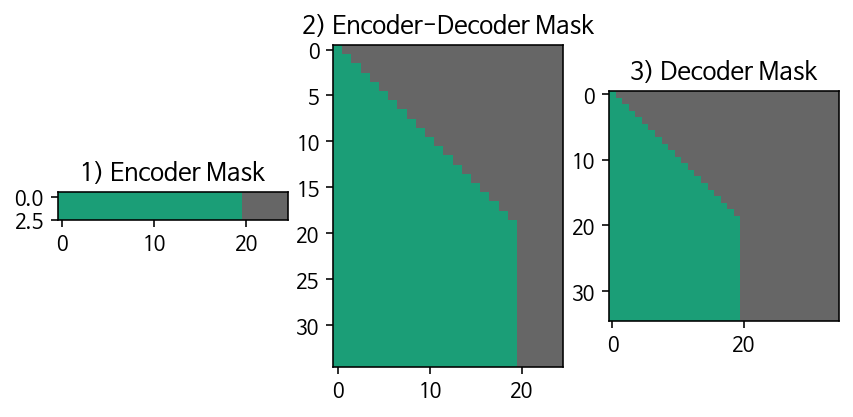

(16, 1, 1, 25)
(16, 1, 35, 25)
(16, 1, 35, 35)


In [96]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2') 
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

print(enc_mask.numpy().shape)
print(dec_enc_mask.numpy().shape)
print(dec_mask.numpy().shape)

dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask) 에서 (16, 1, 1, 25), (35, 25)끼리 shape가 다른데 어떻게 연산이 되는건지 매우 궁금하다.

첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다. 낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데... 이것이 바로 Causality Mask와 Padding Mask를 결합한 형태입니다! 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 했던 것을 기억하시죠? 인과 관계를 가리는 것도 중요하지만 Decoder 역시 <PAD> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된답니다!  
  
또, 트랜스포머는 고정된 Learning Rate를 사용하지 않았었죠! 논문의 해당 부분을 Optimizer까지 포함하여 다시 한번 살펴봅시다. 이전 노드에서 Learning Rate를 numpy 로 간단히 구현을 했었는데, 이번엔 Tensorflow 상에서 잘 구동될 수 있도록 LearningRateSchedule 클래스를 상속받아 구현해보죠!

In [121]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
    
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                    beta_1 = 0.9,
                                    beta_2 = 0.98,
                                    epsilon = 1e-9)

트랜스포머가 제안한 수식이 아니더라도 가변적인 Learning Rate를 사용하려면 위와 같이 구현을 하시면 됩니다. Optimizer는 논문에 정의된 대로 Adam Optimizer를 사용하며 세부 파라미터도 동일하게 맞춰 줍니다.